In [27]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("/media/hdd/github/sprintdl/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from sprintdl.main import *
import sprintdl

In [29]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

In [30]:
from sprintdl.models.xresnet import *

# Define required

In [31]:
fpath = Path("/media/hdd/Datasets/DenseHaze/")

# train_transform = [A.Resize(128,128)]

# tfms = [ATransform(train_transform, c_in = 3)]
image_size = 128
tfms = [make_rgb,to_byte_tensor,to_float_tensor, ResizeFixed(image_size)]
bs = 64

In [32]:
fpath_mask = fpath/"train"
fpath_ims = fpath/"masks"

# Actual process

In [33]:
il = ImageList.from_files(fpath_ims, tfms=tfms)

In [34]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))

In [39]:
def return_mask(fpath_ims, fpath_mask,name):
    return open_image(from_another_folder(fpath_ims, fpath_mask,name),size = (image_size,image_size), convert_to="RGB",to_tensor=True)

In [40]:
ll = label_by_func(sd, lambda x: return_mask(fpath_ims, fpath_mask, x))

In [41]:
n_classes = len(set(ll.train.y.items));n_classes

data = ll.to_databunch(bs, c_in=3, c_out=n_classes)

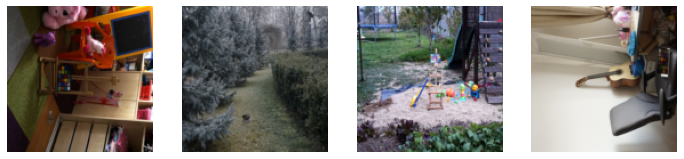

In [42]:
show_batch(data,4)

# Training

In [51]:
lr = .001
pct_start = 0.3
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

# def loss_funct(input, target):
# #     print(input.shape, target.shape)
#     return nn.BCEWithLogitsLoss()(input, target) 
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def loss_funct(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss

cbfs = [
    partial(AvgStatsCallback,loss_funct),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]




loss_func=loss_funct
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [52]:
def conv_layer(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])

        self.layer0_1x1 = conv_layer(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])

        self.layer1_1x1 = conv_layer(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = conv_layer(128, 128, 1, 0)

        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = conv_layer(256, 256, 1, 0)

        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = conv_layer(512, 512, 1, 0)

        self.upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = conv_layer(256+512, 512, 3, 1)
        self.conv_up2 = conv_layer(128+512, 256, 3, 1)
        self.conv_up1 = conv_layer(64+256, 256, 3, 1)
        self.conv_up0 = conv_layer(64+256, 128, 3, 1)

        self.conv_original_size0 = conv_layer(3, 64, 3, 1)
        self.conv_original_size1 = conv_layer(64, 64, 3, 1)
        self.conv_original_size2 = conv_layer(64+128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)
#         print(out.shape)
#         out = out.permute(0, 3, 2, 1)

        return out


In [53]:
arch = UNet(3)
clear_memory()
learn = Learner(arch, data, loss_funct, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [54]:
clear_memory()

In [55]:
learn.fit(20)

epoch,train_loss,train_loss_funct,valid_loss,valid_loss_funct,time
0,0.562536,0.562536,0.556614,0.556614,00:04
1,0.559592,0.559592,0.550454,0.550453,00:04
2,0.553948,0.553948,0.520942,0.520942,00:04
3,0.523420,0.523420,0.696754,0.696754,00:04
4,0.605615,0.605615,0.516096,0.516096,00:04
5,0.515867,0.515867,0.529748,0.529748,00:04
6,0.531621,0.531621,0.518848,0.518848,00:03
7,0.522262,0.522262,0.501316,0.501316,00:03
8,0.505788,0.505788,0.492670,0.492670,00:03
9,0.497572,0.497572,0.499802,0.499802,00:03


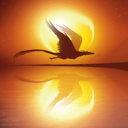

In [66]:
open_image("/media/hdd/ART/refs/beings/dragons/707acb9c40491226f69b48010cb7646b.png",(128,128))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


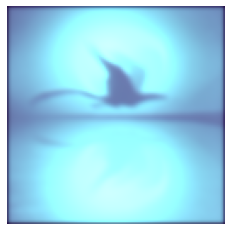

In [68]:
predict_image(learn, (128,128), "/media/hdd/ART/refs/beings/dragons/707acb9c40491226f69b48010cb7646b.png", convert_to="RGB",plot = True)

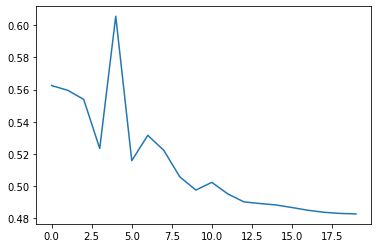

In [60]:
learn.recorder.plot_loss()

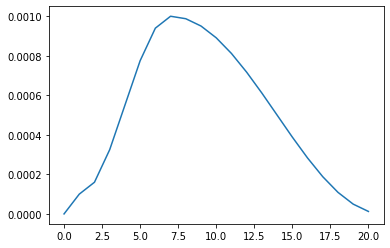

In [61]:
learn.recorder.plot_lr()